In [1]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import time
import copy

In [ ]:
import torchvision.models as models

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir(os.path.join('drive', 'MyDrive'))

https://github.com/fferlito/Cat-faces-dataset

In [ ]:
from typing import Tuple, Any

class AlbumentationsImageFolder(ImageFolder):
    def __init__(self, path, transforms):
        super(AlbumentationsImageFolder, self).__init__(path, transform=transforms)
    
    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        """
        Args:
            index (int): Index

        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        """
        path, target = self.samples[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = np.array(sample)
            sample = self.transform(image=sample)
        if self.target_transform is not None:

            target = self.target_transform(target)

        return sample['image']/1.0, target

In [ ]:
from sklearn.utils import shuffle


class MyDataLoaderIterator():
  def __init__(self, loader):
    self.loader = loader

  def __next__(self):
    labels = []
    data = []
    for kubik_index in range(self.loader.kubik_len):
        #print(kubik_index)
        for i in range(self.loader.repeats):
            kubik = self.loader.dataset[kubik_index]
            data.append(kubik[0])
            labels.append(kubik[1])
    #print('kubik sampled')
    rng = np.random.default_rng()
    indices = rng.choice(np.arange(self.loader.kubik_len, len(self.loader.dataset)), size=self.loader.kubik_size, replace=False)
    for not_kubik_index in indices:
        not_kubik = self.loader.dataset[not_kubik_index]
        data.append(not_kubik[0])
        labels.append(not_kubik[1])
    #print('rest sampled')
    data, labels = shuffle(data, labels)
    return torch.stack(data), torch.tensor(labels)
    raise StopIteration

class MyDataLoader():
    def __init__(self, dataset, kubik_len, repeats=5):
        self.dataset = dataset
        self.kubik_len = kubik_len
        self.repeats = repeats
        self.kubik_size = self.kubik_len * self.repeats
        
    def __iter__(self):
        return MyDataLoaderIterator(self)

In [ ]:
!pip install -U git+https://github.com/albumentations-team/albumentations

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-usb_xfep
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-usb_xfep
     |████████████████████████████████| 37.1 MB 48 kB/s 
  Created wheel for albumentations: filename=albumentations-1.1.0-py3-none-any.whl size=102899 sha256=205afe9935e05a4af849cedc27fe41ef5888723596f9d4fac08bfabb21c46b40
  Stored in directory: /tmp/pip-ephem-wheel-cache-_dosps00/wheels/3a/25/ed/ec3b518e7a332d7f0a3bb37c280e1b784cf2f79b94b3c7d00b
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
import albumentations
import albumentations.pytorch as atorch

In [ ]:
albumentations_transform = albumentations.Compose([
    albumentations.Resize(64, 64),
    albumentations.RandomCrop(55, 55),
    atorch.ToTensorV2()
])

albumentations_transform_oneof = albumentations.Compose([
    albumentations.Resize(64, 64), 
    albumentations.RandomCrop(55, 55),
    albumentations.OneOf([
                          albumentations.HorizontalFlip(p=1),
                          albumentations.RandomRotate90(p=1),
                          albumentations.VerticalFlip(p=1)            
    ], p=1),
    albumentations.OneOf([
                          albumentations.MotionBlur(p=1),
                          albumentations.OpticalDistortion(p=1),
                          albumentations.GaussNoise(p=1)                 
    ], p=1),
    atorch.ToTensorV2()
])

cats_train = AlbumentationsImageFolder('./cats/train', albumentations_transform_oneof)
cats_test = AlbumentationsImageFolder('./cats/test', albumentations_transform)

In [ ]:
len(cats_train)

1060

In [ ]:
len(cats_test)

530

In [ ]:
cats_train[0][0]

tensor([[[ 80.,  87.,  82.,  ...,  86.,  87.,  87.],
         [105., 103.,  96.,  ...,  80.,  80.,  80.],
         [113., 102.,  96.,  ...,  79.,  77.,  76.],
         ...,
         [ 62.,  59.,  53.,  ..., 109., 111., 118.],
         [ 74.,  67.,  61.,  ..., 113., 118., 126.],
         [ 93.,  81.,  72.,  ..., 105., 109., 113.]],

        [[ 71.,  78.,  71.,  ...,  58.,  57.,  57.],
         [ 95.,  93.,  84.,  ...,  53.,  53.,  53.],
         [103.,  92.,  85.,  ...,  51.,  50.,  48.],
         ...,
         [ 59.,  56.,  50.,  ...,  88.,  90.,  97.],
         [ 71.,  64.,  58.,  ...,  93.,  98., 106.],
         [ 90.,  79.,  69.,  ...,  85.,  89.,  93.]],

        [[ 61.,  69.,  63.,  ...,  50.,  49.,  49.],
         [ 86.,  84.,  76.,  ...,  45.,  45.,  45.],
         [ 94.,  83.,  76.,  ...,  45.,  43.,  42.],
         ...,
         [ 52.,  49.,  43.,  ...,  80.,  81.,  87.],
         [ 63.,  56.,  51.,  ...,  85.,  89.,  97.],
         [ 78.,  66.,  59.,  ...,  77.,  81.,  85.]]]

In [ ]:
def plot_image(image, truth=None, pred=None):
    if truth is not None and pred is not None:
      if truth == 0:
        truth = 'Kubik'
      else:
        truth = 'Not Kubik'
      if pred == 0:
        pred = 'Kubik'
      else:
        pred = 'Not Kubik'
      plt.title('truth: ' + truth + ', pred: ' + pred)
    plt.imshow(image.int().permute(1,2,0))
    plt.show()

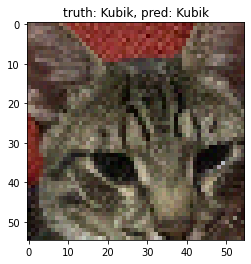

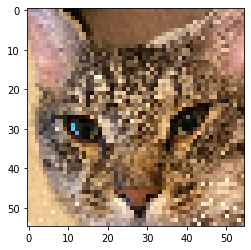

In [ ]:
plot_image(cats_train[0][0], 0, 0)
plot_image(cats_test[1][0])

In [ ]:
kubik_label = cats_train[0][1]
not_kubik_label = 1 - kubik_label

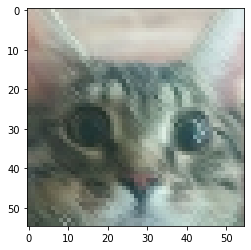

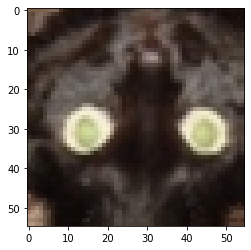

In [ ]:
kubik_train_len = 60
plot_image(cats_train[3])
plot_image(cats_train[kubik_train_len])

In [ ]:
kubik_test_len = 30
train_loader = MyDataLoader(cats_train, kubik_train_len)
test_loader = MyDataLoader(cats_test, kubik_test_len)
#next(iter(loader))

In [ ]:
from IPython.display import clear_output

class EpochPlotter():
  def __init__(self):
    self.current_epoch = 0
    self.epochs_axis = []
    self.train_losses = []
    self.test_losses = []
    self.train_accuracies = []
    self.test_accuracies = []

  def __call__(self, train_loss, train_accuracy, test_loss, test_accuracy):
    self.epochs_axis.append(self.current_epoch)
    self.train_losses.append(train_loss)
    self.train_accuracies.append(train_accuracy)
    self.test_losses.append(test_loss)
    self.test_accuracies.append(test_accuracy)
    self.current_epoch += 1

    clear_output(wait=True)
    plt.figure(figsize=(10,5))
    plt.plot(self.epochs_axis, self.train_losses, label="train_loss")
    plt.plot(self.epochs_axis, self.test_losses, label="test_loss")
    plt.plot(self.epochs_axis, self.train_accuracies, '--',label="train_accuracy")
    plt.plot(self.epochs_axis, self.test_accuracies, '--', label="test_accuracy")
    plt.grid()
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

In [ ]:
device = torch.device('cuda')
model = models.squeezenet1_1(pretrained=False).to(device)
import time
loss_fn = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
 
for epoch in range(50):
 
  success_pred = 0
 
  model.train()
 
  part_len = 10
  data, labels = iter(train_loader).__next__()
  data, labels = data.to(device), labels.to(device)

  #print(labels[:10])
  for i in range(int(len(labels)/part_len)):
    cur = part_len*i
    next = part_len*(i+1)
    data_part = data[cur:next]
    labels_part = labels[cur:next]

    y_pred = model(data_part)
    loss = loss_fn(y_pred, labels_part)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    y_classes = y_pred.argmax(axis=1)
    #print(y_classes)
    success_pred += (y_classes == labels_part).sum()
 
  train_accuracy = success_pred/len(labels)
 
  model.eval()
  test_count = 0
  with torch.no_grad():
      time1 = time.time()
      part_len = 10
      data, labels = iter(train_loader).__next__()
      data, labels = data.to(device), labels.to(device)
      for i in range(int(len(labels)/part_len)):
          cur = part_len*i
          next = part_len*(i+1)
          data_part = data[cur:next]
          labels_part = labels[cur:next]
          y_pred = model(data_part)
          test_count += (y_pred.argmax(axis=1) == labels_part).sum()
  test_acc = test_count/len(labels)
 
  print(epoch, " Train acc:", train_accuracy.item(), "   Test accuracy:", test_acc.item())

0  Train acc: 0.49166667461395264    Test accuracy: 0.4866666793823242
1  Train acc: 0.5583333373069763    Test accuracy: 0.5
2  Train acc: 0.5266667008399963    Test accuracy: 0.5383333563804626
3  Train acc: 0.5766666531562805    Test accuracy: 0.5316666960716248
4  Train acc: 0.5699999928474426    Test accuracy: 0.5450000166893005
5  Train acc: 0.6266666650772095    Test accuracy: 0.6166666746139526
6  Train acc: 0.6150000095367432    Test accuracy: 0.5800000429153442
7  Train acc: 0.621666669845581    Test accuracy: 0.5516666769981384
8  Train acc: 0.621666669845581    Test accuracy: 0.59333336353302
9  Train acc: 0.6483333706855774    Test accuracy: 0.7416666746139526
10  Train acc: 0.6966666579246521    Test accuracy: 0.6366666555404663
11  Train acc: 0.7100000381469727    Test accuracy: 0.6183333396911621
12  Train acc: 0.7200000286102295    Test accuracy: 0.6600000262260437
13  Train acc: 0.7116667032241821    Test accuracy: 0.768333375453949
14  Train acc: 0.71833336353302    

In [ ]:
y_pred = model(data)
y_classes = y_pred.argmax(axis=1)